## Importamos las librerias

In [11]:
from wikiframe import Say

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from mlxtend.classifier import StackingCVClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV,cross_val_score, KFold



# Cargamos los datos

In [12]:
#Cargamos los datos
df = pd.read_csv('data/fraude_tc.csv')

In [13]:
#Separamos los datos en variables y objetivo
X = df.drop(['fraud'], axis=1)
y = df['fraud']

## Separación de los datos

In [14]:
#Separamos en datos de entrenamiento y datos de validacion (para hacer un maquetado rápido del modelo, para mayor rigurosidad, usaremos una validación cruzada)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Transformamos los datos

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Pipeline para el preprocesamiento de los datos, en el EDA se observó que hay sólo columnas numéricas
numerical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()) #en el EDA se observó outliers en 3 columnas
])

# Modelo

In [16]:
#Eligimos los mejores clasificadores
random_forest = RandomForestClassifier()
ada_boost = AdaBoostClassifier()
xgb = XGBClassifier()

In [8]:
#Utilizamos StackCVClassifier para combinar los clasificadores y obtener un mejor resultado ()
model = StackingCVClassifier(
    classifiers=[random_forest, ada_boost, xgb],
    meta_classifier=xgb
)

#PipeLine para el modelo general
pipe = Pipeline(steps=[
    ('numerical', numerical),
    ('model', model)
])

In [21]:
#Entrenamos el modelo (maquetacion)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
accuracy_score(y_test, pred)

0.999995

In [25]:
#Entrenamiento del modelo con crossvalidation y KFolds
# En una maquetación anterior se logró 0.999995( 'mejor' ), con crossvalidation se obtiene un 0.999999
score = cross_val_score(pipe, X_train, y_train, cv=KFold(n_splits=5,shuffle=True, random_state=42), scoring='accuracy')
print(score)

[0.999975   0.99999375 0.99999375 0.99999375 0.99999375]


## Resultado

- Obtuvimos una métrica de entrenamiento de  **0.999975** mediante validacion cruzada (cv = 5)
- Finalmente Obtuvimos la métrica con los valores de Test de **0.999995**

In [26]:
#Metricas de evaluación crossvalidation
Say(f'{np.abs(score).min()}').cow_says_good()

 __________ 
< 0.999975 > 
 ---------- 
        \   ^__^ 
         \  (oo)\_______ 
            (__)\ good🥇 )\/\ 
                ||----w | 
                ||     || 


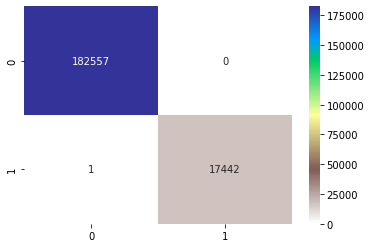

In [38]:
## Predecimos con X_test y obtenemos la matriz de confusión
from matplotlib import pyplot as plt


y_pred = pipe.predict(X_test)
matrx = confusion_matrix(y_test, y_pred)
sns.heatmap(matrx, annot=True, fmt='d', cmap='terrain_r')
plt.show()

In [28]:
accuracy_score(y_test, y_pred)

0.999995

## Guardamos los resultados

In [31]:
import joblib
path = 'models/model.pkl'
joblib.dump(pipe, path)
Say('Modelo entrenado').cow_says_good()

 __________________ 
< Modelo entrenado > 
 ------------------ 
        \   ^__^ 
         \  (oo)\_______ 
            (__)\ good🐶 )\/\ 
                ||----w | 
                ||     || 


## --------------

In [96]:

grid = RandomizedSearchCV(
    pipe,
    param_distributions={
        'model__randomforestclassifier__n_estimators': np.arange(100,1000,100),
        'model__randomforestclassifier__max_depth': np.arange(1,10,1),
        'model__randomforestclassifier__max_features': ['sqrt', 'log2', None],
        'model__randomforestclassifier__bootstrap': [True, False],

        'model__adaboostclassifier__n_estimators': np.arange(100,1000,100),
        'model__adaboostclassifier__learning_rate': np.arange(0.1,1,.1),
        'model__adaboostclassifier__algorithm': ['SAMME', 'SAMME.R'],

        'model__xgboostclassifier__n_estimators': np.arange(100,1000,100),
        'model__xgboostclassifier__max_depth': np.arange(1,10,1),
        'model__xgboostclassifier__learning_rate': np.arange(0.1,1,0.1),
        'model__xgboostclassifier__gamma': np.arange(0,1,0.1),
    },
    cv=5,
    n_iter=5,
    scoring='accuracy'
)

In [ ]:
for param in grid.get_params().keys():
    print(param)    

In [ ]:
grid.fit(X, y)
print('Score: ',np.abs(grid.best_score_))